In [278]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [311]:
from pathlib import Path
import pandas as pd
from bramm_data_analysis import loading
from sklearn import preprocessing
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt

In [280]:
columns = {}

columns["metadata"] = [
    "site_code",
    "site_insee_code",
    "department_code",
    "latitude",
    "longitude",
    "x_lambert",
    "y_lambert",
    "altitude",
    "date",
    "sample_code",
    "sample_send_europe",
]
columns["sample"] = [
    "strand_size",
    "visible_dust_particles",
    "visible_pollen_particles",
    "mineral_type",
]
columns["site"] = [
    "samples_nb",
    "fern_samples_nb",
    "tree_samples_nb",
    "herb_samples_nb",
    "litter_samples_nb",
    "humus_samples_nb",
    "soi_samples_nb",
    "sand_samples_nb",
    "hard_strain_coniferous_samples_nb",
    "hard_strain_hardwood_samples_nb",
    "hard_strain_unknown_samples_nb",
    "decomposed_strain_coniferous_samples_nb",
    "decomposed_strain_hardwood_samples_nb",
    "decomposed_strain_unknown_samples_nb",
    "bark_coniferous_nb",
    "bark_hardwood_samples_nb",
    "bark_unknown_samples_nb",
    "hard_coniferous_samples_nb",
    "hard_hardwood_samples_nb",
    "hard_unknown_samples_nb",
    "decomposed_coniferous_samples_nb",
    "decomposed_hardwood_samples_nb",
    "decomposed_unknown_samples_nb",
]
columns["studies"] = [
    "sample_outside_complementary_study",
    "cs_3_species_comparison",
    "cs_2_species_comparison",
    "cs_repeated_sampling",
    "cs_repeated_analysis",
]
columns["incertitudes"] = [
    "aluminium_incertitude",
    "arsenic_incertitude",
    "calcium_incertitude",
    "cadmium_incertitude",
    "cobalt_incertitude",
    "chromium_incertitude",
    "copper_incertitude",
    "iron_incertitude",
    "mercury_incertitude",
    "nitrogen_incertitude",
    "sodium_incertitude",
    "nickel_incertitude",
    "lead_incertitude",
    "sulfur_incertitude",
    "zinc_incertitude",
]
columns["categorical"] = [
    "weather",
    "tree_layer",
    "tree_layer_complement",
    "tree_cover",
    "species",
]

In [281]:
df_sites = loading.load_sites(Path("../data/Mines_2024.xlsx"))
df_samples = loading.load_samples(Path("../data/Mines_2024.xlsx"))
df_values = loading.load_values(Path("../data/Mines_2024.xlsx"))

In [282]:
df = pd.merge(
    pd.merge(
        df_sites,
        df_samples,
        on="site_code",
    ),
    df_values,
    on="sample_code",
)
# Correct Data
df.loc[
    df["tree_layer_complement"].isna(), "tree_layer_complement"
] = "unspecified"

In [305]:
metadata = df[columns["metadata"]]
site_info = df[columns["site"]]
samples_info = df[columns["sample"]]
studies = df[columns["studies"]]
incertitudes = df[columns["incertitudes"]]
data = df.drop(
    columns=columns["metadata"]
    + columns["sample"]
    + columns["studies"]
    + columns["site"]
    + columns["incertitudes"]
)

# One-Hot encoding
encoder = preprocessing.OneHotEncoder(
    sparse_output=False, handle_unknown="ignore"
)
categorical = pd.concat(
    [data.pop(col) for col in columns["categorical"]], axis=1
)
data_one_hot = encoder.fit_transform(categorical)
categories = encoder.categories_
unwrap_categories = []
for i in range(len(categories)):
    cat = columns["categorical"][i]
    cats = categories[i]
    unwrap_categories.append([f"{cat}_{c}" for c in cats])
categories_encoded = pd.DataFrame(
    columns=np.concatenate(unwrap_categories), data=data_one_hot
)
data = pd.concat([data, categories_encoded], axis=1)

# Correct data
for col in [
    "sodium",
    "platinium",
    "rhodium",
    "antimony",
    "strontium",
    "vanadium",
    "zinc",
]:
    data[col] = data[col].astype(str)
    data[col] = data[col].apply(lambda x: x.replace(",", "."))
    data[col] = data[col].apply(lambda x: x.replace("< ", ""))
    data[col].astype("float64")
data = data.astype("float64")

# Remove Columns with nans
print("The following columns contains NaN and will be removed :")
print(data.columns[data.isna().any(axis=0)])
data = data.drop(columns=data.columns[data.isna().any(axis=0)])

The following columns contains NaN and will be removed :
Index(['mercury', 'nitrogen', 'palladium', 'platinium', 'rhodium', 'sulfur',
       'strontium'],
      dtype='object')


In [306]:
data

,aluminium,arsenic,calcium,cadmium,cobalt,chromium,copper,iron,sodium,nickel,...,tree_layer_complement_unspecified,tree_cover_25-50 %,tree_cover_5-25 %,tree_cover_50-75 %,tree_cover_75-100 %,species_Hc BM,species_Hs,species_Pp,species_Ps,species_Tt
0,256.0,0.154,4850.0,0.160,0.229,0.835,4.46,299.0,138.0,0.758,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,776.0,0.201,5130.0,0.147,0.310,10.000,5.13,458.0,203.0,3.260,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,266.0,0.141,3720.0,0.100,0.198,0.694,5.71,302.0,252.0,0.665,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,932.0,0.165,3740.0,0.116,0.261,1.630,5.34,497.0,292.0,0.913,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,259.0,0.161,3630.0,0.101,0.254,0.724,6.56,286.0,159.0,0.984,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,1260.0,0.569,5440.0,0.188,0.406,1.990,9.74,629.0,156.0,2.410,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1129,429.0,0.255,6490.0,0.114,0.249,0.907,4.68,540.0,50.3,0.725,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1130,842.0,0.299,6650.0,0.108,0.283,1.290,5.79,713.0,44.0,0.902,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1131,406.0,0.196,6260.0,0.111,0.284,1.070,4.29,436.0,30.0,1.690,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [316]:
pca = decomposition.PCA(n_components=32)
data_pca = pca.fit_transform(data)

In [317]:
pca.explained_variance_

array([4.32532712e+06, 1.26531819e+06, 4.99400601e+04, 2.21296825e+04,
       1.89199573e+02, 3.45687581e+01, 3.37730126e+00, 1.52884195e+00,
       7.13384830e-01, 5.35201691e-01, 4.04027946e-01, 3.86995287e-01,
       3.26850655e-01, 2.14612438e-01, 1.89974257e-01, 1.60886090e-01,
       1.44266992e-01, 1.38319576e-01, 1.24946035e-01, 9.35635912e-02,
       4.50560738e-02, 3.33009464e-02, 1.05081632e-02, 7.49416422e-03,
       5.15928056e-03, 2.99723057e-03, 2.11219319e-26, 2.11219319e-26,
       2.11219319e-26, 2.11219319e-26, 2.11219319e-26, 2.11219319e-26])

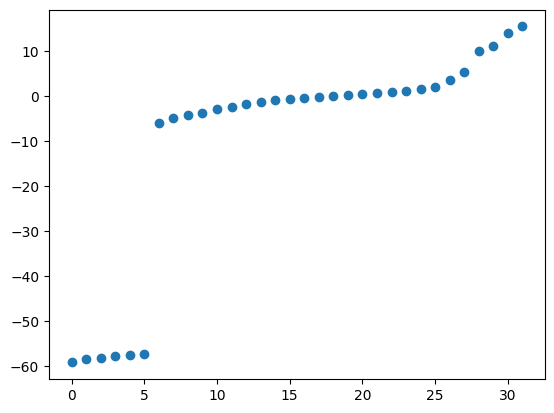

In [326]:
plt.scatter(
    [i for i in range(len(pca.explained_variance_))],
    np.log(pca.explained_variance_[::-1].cumsum()),
)

In [330]:
df["species"].shape

(1133,)

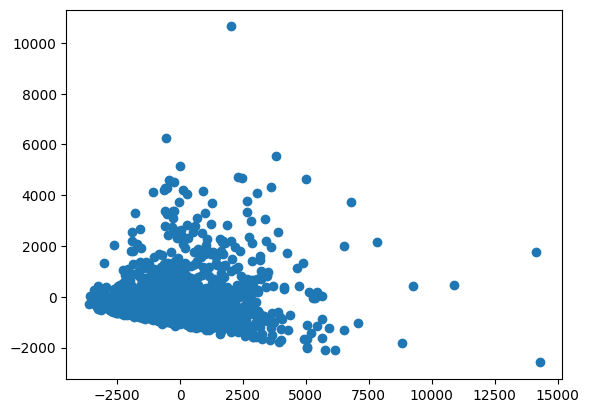

In [333]:
plt.scatter(data_pca[:, 0], data_pca[:, 1])